In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

In [2]:
db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

In [3]:
sql = f'SELECT * FROM openmap_buildings_200814'

df = gpd.read_postgis(sql, engine, geom_col='geometry')
df.shape

(14309868, 3)

In [4]:
auth = gpd.read_file('https://opendata.arcgis.com/datasets/7f83b82ef6ce46d3a5635d371e8a3e7c_0.geojson')

In [5]:
auth = auth.to_crs(df.crs)

In [6]:
df.geometry = df.centroid

In [7]:
inp, res = df.sindex.query_bulk(auth.geometry, predicate='intersects')

In [8]:
import numpy as np

u, c = np.unique(inp, return_counts=True)

In [9]:
auth.loc[u, 'counts'] = c

<AxesSubplot:>

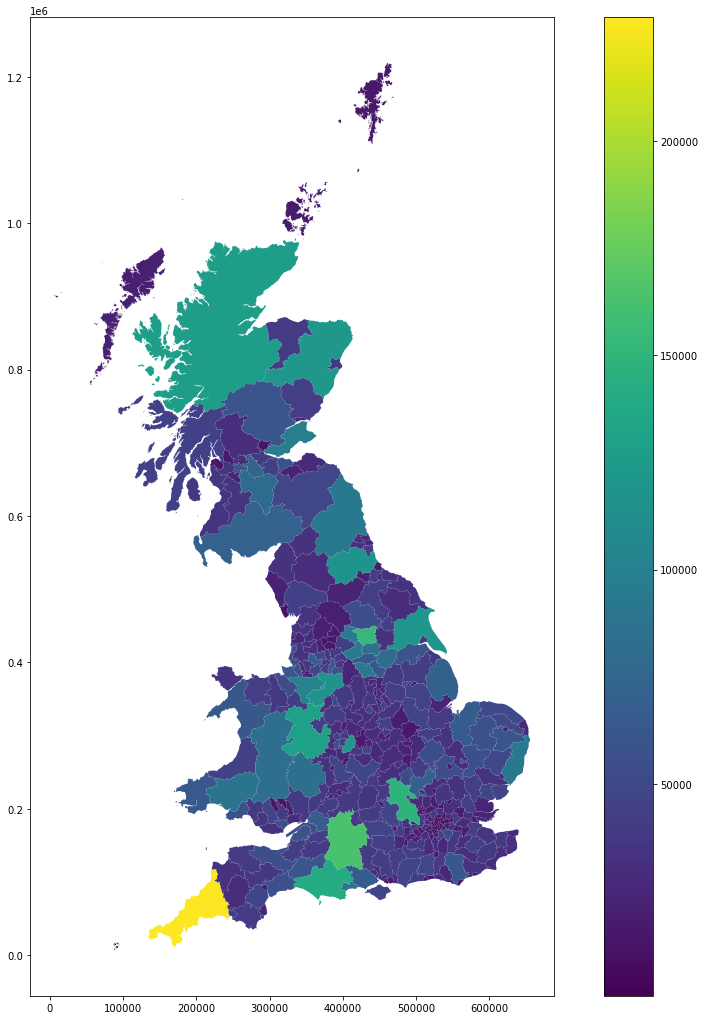

In [11]:
auth.plot('counts', figsize=(18, 18), legend=True)

In [12]:
auth.to_parquet('../../urbangrammar_samba/local_authorities.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [13]:
auth['counts'].describe()

count       368.000000
mean      38885.456522
std       26273.929125
min         484.000000
25%       23604.250000
50%       34107.500000
75%       43683.000000
max      228957.000000
Name: counts, dtype: float64

## Geo-chunking Local Authority Districts

On this section we will create a partition of the UK that groups spatially contiguous local authorities (LADs) in *regions* that have similar number of buildings. For that, we will employ a regionalisation algorithm.

In [46]:
import geopandas
from libpysal.weights import Queen, KNN, w_union

In [5]:
auth = geopandas.read_parquet("local_authorities.pq")

Note that we need to install [`region`](https://github.com/pysal/region) for this operation. The library is not part of `gds_env:5.0` as it has been phased out in benefit of [`spopt`](https://github.com/pysal/spopt), which will eventually be part of PySAL.

In [13]:
! pip install region
import region

First we need to record topology. We are going to create a mix of contiguity and nearest-neighbors.

In [42]:
%time w_queen = Queen.from_dataframe(auth)

CPU times: user 2min 49s, sys: 13.3 s, total: 3min 2s
Wall time: 3min 1s


/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 6 islands with ids: 43, 49, 330, 337, 339, 357.
  warnings.warn(message)


In [65]:
%time w_k1 = KNN.from_dataframe(auth, k=2)

CPU times: user 294 ms, sys: 8.67 ms, total: 303 ms
Wall time: 305 ms


/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


And then combine both through the union:

In [66]:
w = w_union(w_queen, w_k1)

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


And we are ready to regionalise!

In [90]:
%%time
from region.max_p_regions.heuristics import MaxPRegionsHeu
model = MaxPRegionsHeu(random_state=123445)
model.fit_from_w(w, 
                 auth.assign(ones=1)[["ones"]].values, 
                 spatially_extensive_attr=auth["counts"].values, 
                 threshold=100000
                )

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


ValueError: list.remove(x): x not in list

In [28]:
import pandas
pandas.Series(model.labels_).unique().shape

(379,)

In [25]:
auth.groupby(model.labels_)["counts"].sum()

0.0      40705.0
1.0      54500.0
2.0      28490.0
3.0      93229.0
4.0      52337.0
          ...   
374.0    19580.0
375.0    49691.0
376.0    24969.0
377.0    34991.0
378.0        0.0
Name: counts, Length: 379, dtype: float64

ValueError: Invalid scheme. Scheme must be in the set: dict_keys(['boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 'jenkscaspall', 'jenkscaspallforced', 'jenkscaspallsampled', 'maxp', 'maximumbreaks', 'naturalbreaks', 'quantiles', 'percentiles', 'stdmean', 'userdefined'])

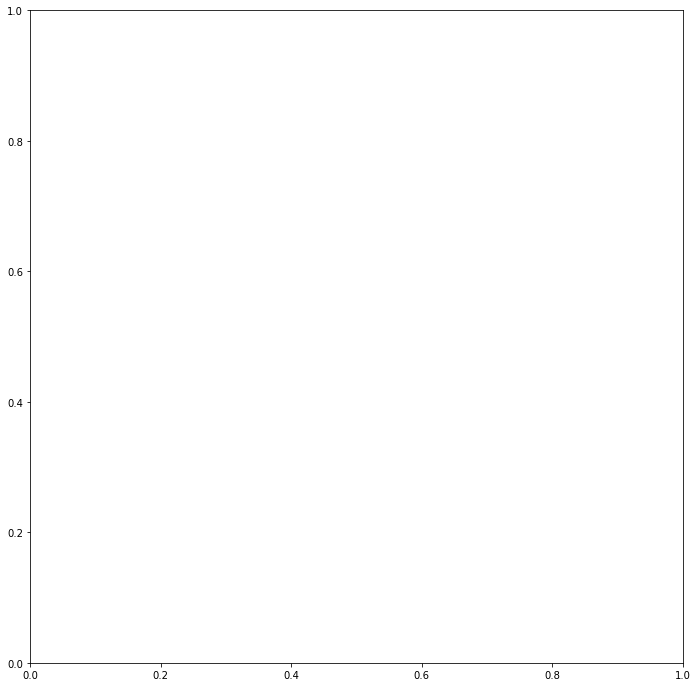

In [24]:
auth.assign(lbls=model.labels_)\
    .plot(column="lbls",
          scheme="greedy",
          categorical=True,
          figsize=(12, 12)
         )